In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
hares= pd.read_csv(os.path.join('data','knb-lter-bnz','55_Hare_Data_2012.txt'))
hares.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
0,11/26/1998,NaN,bonrip,1A,414D096A08,NaN,NaN,NaN,1370.0,160.0,NaN,917.0,51,Population
1,11/26/1998,NaN,bonrip,2C,414D320671,NaN,M,NaN,1430.0,NaN,NaN,936.0,51,Population
2,11/26/1998,NaN,bonrip,2D,414D103E3A,NaN,M,NaN,1430.0,NaN,NaN,921.0,51,Population
3,11/26/1998,NaN,bonrip,2E,414D262D43,NaN,NaN,NaN,1490.0,135.0,NaN,931.0,51,Population
4,11/26/1998,NaN,bonrip,3B,414D2B4B58,NaN,NaN,NaN,1710.0,150.0,NaN,933.0,51,Population


In [4]:
hares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3380 non-null   object 
 1   time        264 non-null    object 
 2   grid        3380 non-null   object 
 3   trap        3368 non-null   object 
 4   l_ear       3332 non-null   object 
 5   r_ear       3211 non-null   object 
 6   sex         3028 non-null   object 
 7   age         1269 non-null   object 
 8   weight      2845 non-null   float64
 9   hindft      1633 non-null   float64
 10  notes       243 non-null    object 
 11  b_key       3333 non-null   float64
 12  session_id  3380 non-null   int64  
 13  study       3217 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 369.8+ KB


In [5]:
hares['date'] = pd.to_datetime(hares['date'])
print(hares.date.dtype)

datetime64[ns]


In [6]:
# Examine unique values and counts in age column
pd.DataFrame(hares['age'].value_counts(dropna=False))

,count
age,
NaN,2111
A,564
J,267
a,183
j,128
1/2/2013,21
1/4/2013,21
3/4/2013,18
1,12


In [7]:
# Update age values to juvenile and adult for observations where 'a' and 'j' are included
hares.loc[hares.age.str.contains('j', case=False, na=False), 'age'] = 'juvenile'
hares.loc[hares.age.str.contains('a', case=False, na=False), 'age'] = 'adult'

# Filter for confirmed observations of juvenile and adult hares
hares_juv_adult = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(f"Number of selected juvenile and adult hares: {len(hares_juv_adult)}")

Number of selected juvenile and adult hares: 1155


In [8]:
# Extract year in which each observation happened
hares_juv_adult['year'] = hares_juv_adult.date.dt.year

# Create hares/year dataframe
hares_per_year = (hares_juv_adult.groupby(['year','age']).size()   # Note: size() counts all elements, including NAs
                                 .reset_index(name='counts')       # Remove multi-index
                                 .pivot(index='year', columns='age', values='counts')   # Pivot into long format
                                 )
hares_per_year

age,adult,juvenile
year,,
1999,150.0,126.0
2000,159.0,67.0
2001,72.0,22.0
2002,3.0,NaN
2003,1.0,18.0
2004,NaN,8.0
2005,95.0,48.0
2006,101.0,15.0
2007,13.0,5.0


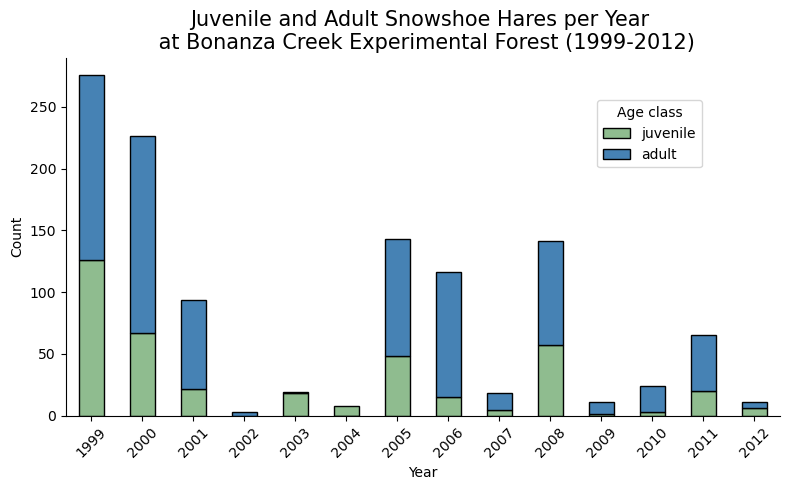

In [9]:
# Create figure + axes
fig, ax = plt.subplots(figsize=(8, 5))

hares_per_year[['juvenile', 'adult']].plot(    # Rearrange columns for stacking order
    kind='bar',
    stacked=True,
    ax=ax,
    edgecolor='black',
    color=["#8FBC8F", "#4682B4"], 
)

# Labels, title, and legend
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Juvenile and Adult Snowshoe Hares per Year \n at Bonanza Creek Experimental Forest (1999-2012)",
             {'fontsize':15})
ax.legend(title="Age class",
         loc="upper right",   
         bbox_to_anchor=(0.9, 0.9))

# Axes and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Consider the following question: In what ways could the data collection methods affect the results we see here?
***
It seems that many of the differences seem to be due to some sort of sampling error. Not only is there a year where there were no measurements, which skews the mean, but they also seem to consistenty undermeasure the juvenile poppulation. This could be due to issues with the mark-recapture method, or some other variable. This is obvious in years like 2004 and 2007 where there where basically no juvelines or adults, only for the next year to suddenly have an extreme increase in adult hares. This indicates that juveniles had been severly undercounted in previous years as these adults didn't simply appear out of nowhere.

Number of juvenile hares with hind foot and weight measurements: 265


<Axes: xlabel='hindft', ylabel='weight'>

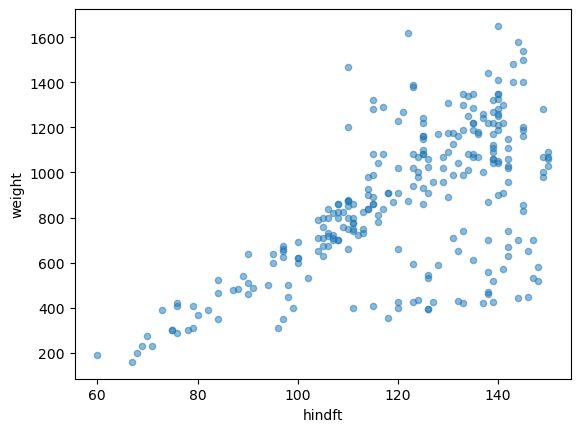

In [10]:
# Subset juvenile hares with hind foot and weight measurements
juveniles_weight_hindft = hares_juv_adult[(hares_juv_adult['hindft'].notna()) & 
                                          (hares_juv_adult['weight'].notna()) &
                                          (hares_juv_adult['age']=='juvenile')]


print(f"Number of juvenile hares with hind foot and weight measurements: {len(juveniles_weight_hindft)}")
juveniles_weight_hindft.plot.scatter(x='hindft', y='weight', alpha=0.5)

In [11]:
# x-values
X = np.array(juveniles_weight_hindft['hindft']).reshape((-1, 1))   # Reshape to (n_samples, 1)
print(f"Input data shape: {X.shape}")

# y-values
y = np.array(juveniles_weight_hindft['weight'])    # Shape is (n_samples,)
print(f"Output data shape: {y.shape}")

Input data shape: (265, 1)
Output data shape: (265,)


In [12]:
# Fit model
model = LinearRegression().fit(X, y)

# Calculate R^2
R_sq = model.score(X, y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")

Coefficient of determination (R^2): 0.3871164783665736
x-axis intercept: -352.77198564640594
Slope: 10.092239638623006


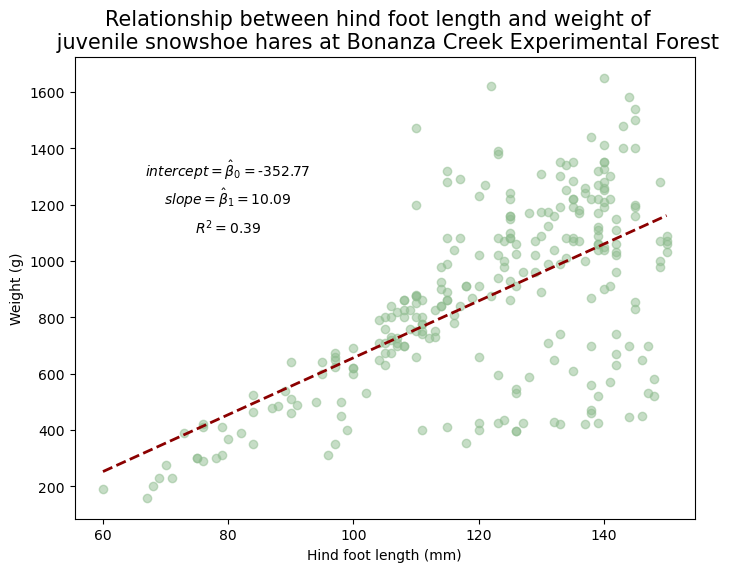

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x=juveniles_weight_hindft['hindft'], 
           y=juveniles_weight_hindft['weight'], 
           alpha=0.5,
           color='#8FBC8F')

# Define parameters of the regression line
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# Plot the line
ax.plot([x_start, x_end], 
        [slope*x_start + intercept, slope*x_end + intercept],
        color="darkred", 
        lw=2, 
        linestyle="--")

# Add the parameters
beta0 = r'$intercept = \hat\beta_0 =$'+ str(round(intercept,2))
ax.text(80, 1300, beta0, fontsize=10, horizontalalignment='center')

beta1 = r'$slope = \hat\beta_1 =$' + str(round(slope,2))
ax.text(80, 1200, beta1, fontsize=10, horizontalalignment='center')

r_squared = r'$R^2 =$' + str(round(R_sq,2))
ax.text(80, 1100, r_squared, fontsize=10, horizontalalignment='center')        

# Add a title and axis label
ax.set_title('Relationship between hind foot length and weight of  \n juvenile snowshoe hares at Bonanza Creek Experimental Forest',
             {'fontsize':15})
ax.set_xlabel('Hind foot length (mm)')
ax.set_ylabel('Weight (g)')

# Show the plot
plt.show()


###Answer the following questions:
***

1. Does it make sense to interpret the axis intercept as an estimated measurement of weight?
    No, as the intercept, -352,77 mm, is not possible. Can't have a negative measuremnt of feet

2. What is the estimated change in weight for each millimiter increase in hind foot length?
    10.08 mm

3. Does a linear model of weight with respect to hind foot length account completely for the change in the dependent variable? What other variables could be worth exploring to model the weight?
    No. We can clearly see that there are two groups in the data, each with different slopes. This is likely caused by gender or some other grouping variable, which should be added into the model.

4. How would you use the linear model to estimate the weight of a juvenile hare with hind foot length of 90 mm?
    I plug in the value of 90 to the model and solve the equation, which gives the result of 555.33 g. Alternatively, I could find this point on the line. For a more precise measure I would likely include standard deviation in my answer and add it as ± 1.96*SD.